To verify that the model has learnt a feature of the data as opposed to an artifact, some visualisation methods are implemented.

First,  the test generator is defined and the model is loaded with the trained weights.

In [1]:
# Standard imports 
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import random

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
test_dir = 'Neuron Cy5 Test Data'
input_size = 331

# Keras data generator to load image samples in batches
data_gen = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True)
test_gen = data_gen.flow_from_directory(test_dir,
                                        target_size=(input_size,input_size),
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=1,
                                        shuffle=True)

classes = dict((v, k) for k, v in test_gen.class_indices.items())
num_classes = len(classes)
num_samples = len(test_gen)

Found 100 images belonging to 2 classes.


In [3]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications import VGG19
from tensorflow.python.keras.layers import GlobalMaxPooling2D, Dense

# Create a VGG19 architecture
pretrained_model = VGG19(include_top=False,
                         pooling='none',
                         input_shape=(input_size, input_size, 3),
                         weights=None)
x = GlobalMaxPooling2D()(pretrained_model.output)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
vgg19_model = Model(pretrained_model.input, output)

# Create new model with modified config which accepts the input shape: [input_size, input_size, 1]
cfg = vgg19_model.get_config()
cfg['layers'][0]['config']['batch_input_shape'] = (None, input_size, input_size, 1)
model = Model.from_config(cfg)

# Load in the weights from training
weights_dir = 'VGG19_weights.h5'
model.load_weights(weights_dir)

The first visualisation technique is [Grad-CAM](https://arxiv.org/abs/1610.02391). The hope is that this class mapping will highlight neurons - an indication that the CNN is "looking" here as opposed to at some other feature.

To implement this, the model is duplicated with modified gradients and linear activations on the final layer. The modified gradient gives an implementation of [Guided BackPropagation](https://arxiv.org/abs/1412.6806) and only backpropagates gradients at nodes which had positive activation during the forward pass. The linear activation in the final Dense layer ensures that when computing derivatives of a class output that features which minimise the other classes aren't included; as would happen if the final activation were left as softmax.

In [4]:
# Registering GuidedRelu as a tensorflow gradient
try:
    @tf.RegisterGradient('GuidedRelu')
    def _guided_backprop(op, grad):
        dtype = op.outputs[0].dtype
        gate_g = tf.cast(grad > 0., dtype)
        gate_y = tf.cast(op.outputs[0] > 0, dtype)
        return gate_y * gate_g * grad
except KeyError: #KeyError is raised if 'GuidedRelu' has already been registered as a gradient
    pass

In [5]:
from tensorflow.python.keras.activations import linear

cfg = model.get_config()
g = tf.get_default_graph()
# Compiling the model within this loop implements Guided Backprop
with g.gradient_override_map({'Relu': 'GuidedRelu'}):
    # Copying model using it's config
    guid_model = Model.from_config(cfg)
    # Replacing the activation on the last layer with linear
    guid_model.layers[-1].activation = linear
    guid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])

In [6]:
def lcm(a,b):
    '''
    Returns the lowest common multiple of inputs a & b.
    '''
    from math import gcd
    return (a*b)//gcd(a,b)

In [7]:
def unaug_img(img):
    '''
    Returns image array with pixel intensities confined to [0,1].
    '''
    img -= img.min()
    img /= img.max()
    return img

In [8]:
from tensorflow.python.keras import backend as K
def generate_gradcam(img, class_pred, model, last_conv_layer): 
    '''
    Generates Grad-CAM of img with respect to class_pred, given the Keras model and it's last_conv_layer.
    '''
    # Creating the mapping as per the paper
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        class_output = model.output[:, class_pred]
        grads = K.gradients(class_output, last_conv_layer.output)[0]
        weightings = K.mean(grads, axis=(0,1,2))
        # Keras function taking image input and returning the class feature weights and feature map 
        iterate = K.function([model.input], [weightings, last_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([np.reshape(img,(1, input_size, input_size, 1))])
    # Weighted addition of the feature maps
    for i in range(conv_layer_output_value.shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # Global Average Pooling
    heatmap = np.mean(conv_layer_output_value, axis=-1) 
    # Relu
    heatmap = np.maximum(heatmap,0) 
    # Normalize for visualisation
    heatmap /= np.max(heatmap) 
    map_size = lcm(img.shape[0],heatmap.shape[0]) # Assumes square images
    # Resize image and convert to RGB
    img = cv2.resize(img, (map_size,map_size))
    img = np.uint8(255*img) 
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    # Resize heatmap and apply colourmap
    heatmap = cv2.resize(heatmap, (map_size,map_size))
    heatmap = np.uint8(255*heatmap)
    heatmap_jet = cv2.applyColorMap(255-heatmap, cv2.COLORMAP_JET)
    # Remove pixels for which the class activation is low
    heatmap_jet[np.where(heatmap < 75)] = 0
    # Superimpose Grad-CAM with image
    superimposed_img = cv2.addWeighted(img, 0.7, heatmap_jet, 0.3, 0)
    return superimposed_img

Predictions for each image in the test set are generated and the Grad-CAM for the most confident prediction of each class is shown.

In [9]:
y_true = np.empty([num_samples, 2])
y_pred = np.empty([num_samples, 2])
X = np.empty([num_samples, input_size, input_size, 1])
# Get next image from generator and get prediction
for i in range(num_samples):
    prog = ' Progress: '+str(i+1)+'/'+str(num_samples)
    X[i,...], y_true[i,:] = next(test_gen)
    y_pred[i,:] = model.predict(np.expand_dims(X[i,...],axis=0), steps=1)
    sys.stdout.write('\r'+prog)
sys.stdout.write('\rDone                ')

Done                

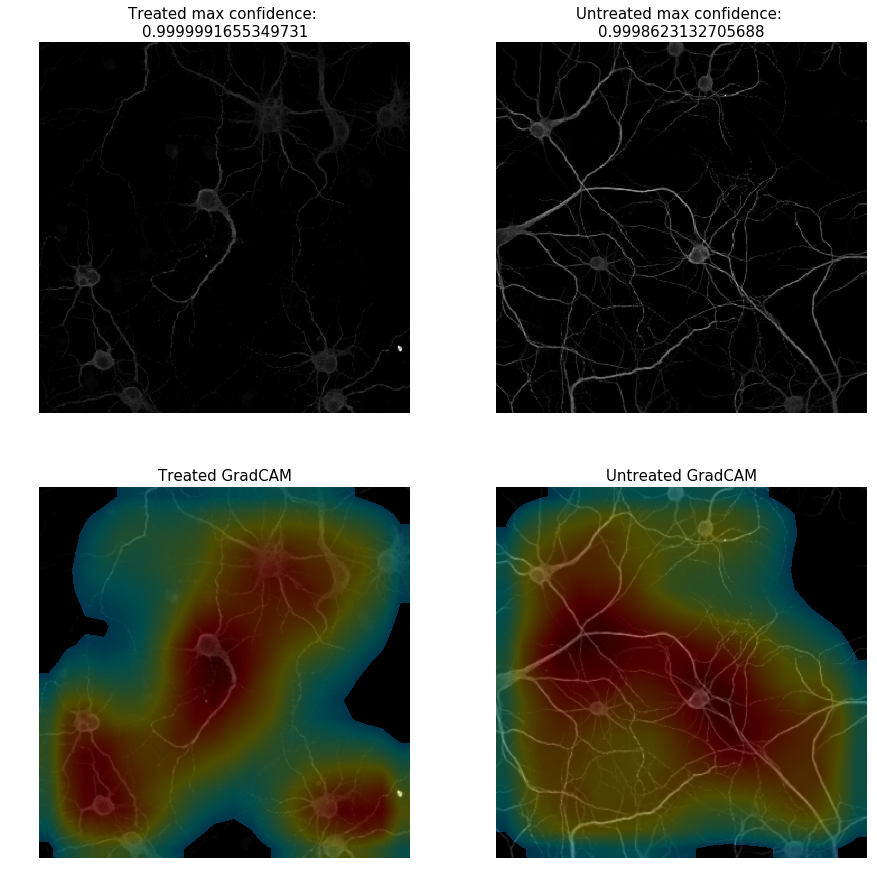

In [10]:
# The last convolutional layer in VGG19 is called 'block5_conv4 in Keras'
last_conv_layer = guid_model.get_layer('block5_conv4')
max_imgs = np.empty([num_classes, input_size, input_size, 1])

fig, ax = plt.subplots(2, num_classes, figsize=(15,15))
for i in range(num_classes):
    #Get most confident prediction
    idx = np.argmax(y_pred[:,i])
    max_imgs[i] = X[idx]
    # Display image
    ax[0,i].set_title(classes[i]+' max confidence: \n'+str(y_pred[idx,i]), fontsize=15)
    ax[0,i].imshow(unaug_img(max_imgs[i,...,0]), cmap='gray')
    ax[0,i].axis('off')
    # Generate Grad-CAM and display it
    gradcam = generate_gradcam(max_imgs[i], i, guid_model, last_conv_layer)
    ax[1,i].set_title(classes[i]+' GradCAM', fontsize=15)
    ax[1,i].imshow(gradcam)
    ax[1,i].axis('off')

The Grad-CAM appears to show the model is indeed "looking" at the Neurons! To get a finer attention map, the [Saliency Map](https://arxiv.org/abs/1312.6034) is created. Using Guided BackPropagation and the linear activations in the final layer as before improves the output of the map.

In [11]:
from tensorflow.python.keras import backend as K
def generate_saliency(img, class_pred, model):
    '''
    Generates the Saliency map of img with respect to class_pred, given the Keras model.
    '''
    inp = model.input
    class_outp = model.output[:, class_pred]
    sal = K.gradients(tf.reduce_sum(class_outp), inp)[0]
    # Keras function returning the saliency map given an image input
    sal_fn = K.function([inp], [sal])
    # Generating the saliency map and normalizing it
    img_sal = sal_fn([np.resize(img, (1, input_size, input_size, 1))])[0]
    img_sal = np.abs(img_sal)
    img_sal /= img_sal.max()
    return img_sal

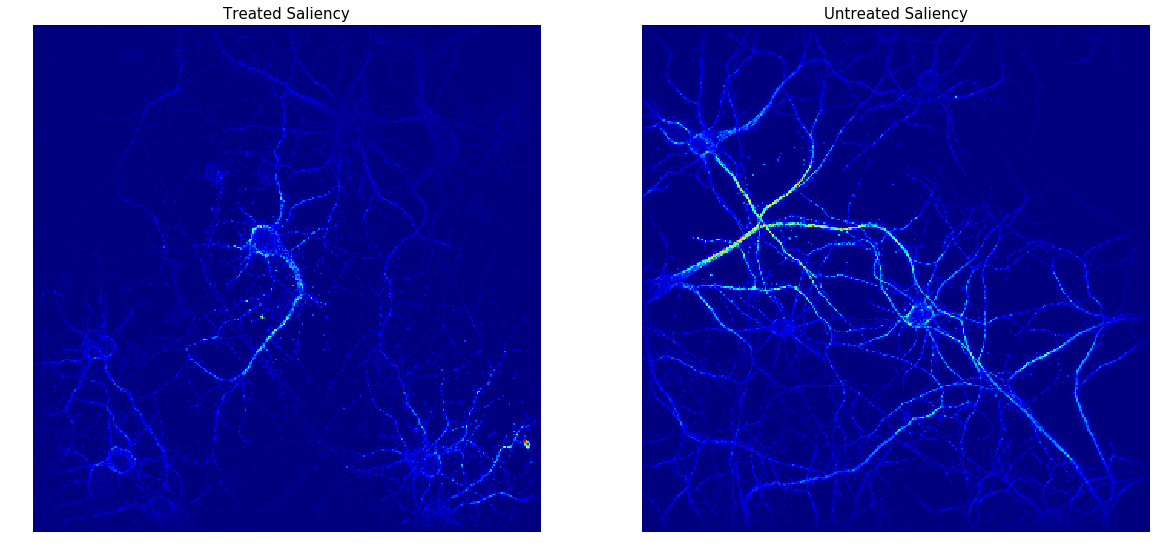

In [12]:
fig, ax = plt.subplots(1, num_classes, figsize=(20,10))
for i in range(num_classes):
    #Generating and showing the Saliency Map for most confident predictions
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saliency = generate_saliency(max_imgs[i], i, guid_model)
    ax[i].set_title(classes[i]+' Saliency', fontsize=15)
    ax[i].imshow(saliency[0,...,0], cmap='jet')
    ax[i].axis('off')